In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np

from DatasetManagerLibs import DatasetConvertor, DatasetReader
from TrafficPredictior.libs import PreparingDatasetCA
from TrafficPredictior.libs import trainModelCA
from TrafficPredictior.libs import evaluateModelCA
from TrafficPredictior.libs import createModelCA
from Configs import getPredictorConfig, visualizePredictorConfig

In [2]:
datasetReader = DatasetReader(parentFolder="Dataset")
datasetConverter = DatasetConvertor()
datasetLabel = "Task0_1_2"
for taskName in ["Task0", "Task1", "Task2"]:
    for fileIndex in datasetReader.readFileIndexsList:
        datasetReader.readRawDataset(f"Dataset/{taskName}/exp{fileIndex}/motion.txt", datasetLabel=datasetLabel)

In [3]:
configIdx = 1
config = getPredictorConfig(configIdx)

lenWindow = config['LEN_window']
upsampleK = config['upsampleK']
dataflow = config['dataflow']
dbParameter = config['dbParameter']
alpha = config['alpha']
mode = config['mode']
direction = config['direction']
train_ratio = config['train_ratio']
trainDataAugment = config['trainDataAugment']
smoothFc = config['smoothFc']
smoothOrder = config['smoothOrder']
visualizePredictorConfig(config)

Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_bk
DB Parameter:           0.012
Alpha:                  0.01
Mode:                   fixed
Direction:              backward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [4]:
datasetConverter.registerDataUnit(datasetReader.dfLibrary[datasetLabel])
datasetConverter.generateTrafficByDpdr(dbParameter=dbParameter, alpha=alpha, mode=mode, direction=direction, upsampleK=upsampleK)
datUnit = datasetConverter.getDataUnit(dataflow)

print(f"================== Training Predictor=================")
trainDataAugment = False
verbose = True

paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = train_ratio
paramsCA['dataAugment'] = trainDataAugment
paramsCA['smoothFc'] = smoothFc
paramsCA['smoothOrder'] = smoothOrder
paramsCA['contextDownsample'] = upsampleK

#============= Training =============
trainData, testData, (newLenSource, newLenTarget) = PreparingDatasetCA(datUnit, paramsCA, verbose=verbose)
(contextSrc, contextTrg, _, trafficSrc, trafficTrg, _, transmissionsVector, contextSrcNoSmooth) = trainData
print(f"Context Source shape: {contextSrc.shape}")
print(f"Context Target shape: {contextTrg.shape}")
print(f"Traffic Source shape: {trafficSrc.shape}")
print(f"Traffic Target shape: {trafficTrg.shape}")
print(f"Transmissions Vector shape: {transmissionsVector.shape}")
print(f"Context Source No Smooth shape: {contextSrcNoSmooth.shape}")

if  paramsCA['contextDownsample'] is not None:
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    newLenSource, newLenTarget, trainData, testData, verbose=verbose)
else:
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=verbose)    

========== thumb ============
Backward: Compression rate:0.365004549992745
========== index ============
Backward: Compression rate:0.3371405289522717
========== middle ============
Backward: Compression rate:0.348122010914217
================== Training Predictor=================
Train size: 624396, Test size: 416265
Context Source shape: (3120, 20, 1)
Context Target shape: (3120, 20, 1)
Traffic Source shape: (3120, 1)
Traffic Target shape: (3120, 1)
Transmissions Vector shape: (3120, 20)
Context Source No Smooth shape: (3120, 20, 1)
Size of train loader: 1, Size of test loader: 1
Used device: cuda
Size of model: 31706
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=231, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2)

Train size: 624396, Test size: 416265


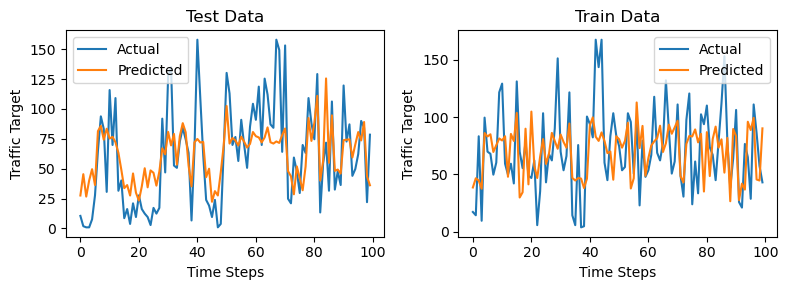

In [5]:
def UpsampleTraffic(traffic, lenWindow,upsampleK):
    return np.interp(
        traffic,
        np.linspace(0, np.floor(lenWindow/upsampleK+1).astype(int), num=lenWindow+1),
        np.linspace(0, lenWindow+1, num=lenWindow+1)
    )
#============= Evaluatation =============
trafficModelCA, _ = createModelCA(modleParametersCA)
trafficModelCA.load_state_dict(bestWeightsCA)
paramsValid = paramsCA.copy()
paramsValid['dataAugment'] = False
trainData, testData, (newLenSource, newLenTarget) = PreparingDatasetCA(datUnit, paramsValid, verbose=verbose)
resultsTrain = evaluateModelCA(trafficModelCA, trainData)
resultsTest = evaluateModelCA(trafficModelCA, testData)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Test data plot
ax1.plot(UpsampleTraffic(resultsTest['trafficTarget_actual'][0:100], lenWindow, upsampleK), label='Actual')
ax1.plot(UpsampleTraffic(resultsTest['trafficTarget_predicted'][0:100], lenWindow, upsampleK), label='Predicted')
ax1.set_title('Test Data')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Traffic Target')
ax1.legend()

# Train data plot
ax2.plot(UpsampleTraffic(resultsTrain['trafficTarget_actual'][0:100], lenWindow, upsampleK), label='Actual')
ax2.plot(UpsampleTraffic(resultsTrain['trafficTarget_predicted'][0:100], lenWindow, upsampleK), label='Predicted')
ax2.set_title('Train Data')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Traffic Target')
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
trafficData = {
    'trafficSource_train_actual':UpsampleTraffic(resultsTrain['trafficSource_actual'], lenWindow, upsampleK),
    'trafficTarget_train_actual': UpsampleTraffic(resultsTrain['trafficTarget_actual'], lenWindow, upsampleK),
    'trafficTarget_train_predicted': UpsampleTraffic(resultsTrain['trafficTarget_predicted'], lenWindow, upsampleK),
    'trafficSource_test_actual':UpsampleTraffic(resultsTest['trafficSource_actual'], lenWindow, upsampleK),
    'trafficTarget_test_actual': UpsampleTraffic(resultsTest['trafficTarget_actual'], lenWindow, upsampleK),
    'trafficTarget_test_predicted': UpsampleTraffic(resultsTest['trafficTarget_predicted'], lenWindow, upsampleK),
}

with open(f'Results/TrafficData/trafficData_{dataflow}_LenWindow{lenWindow}.pkl', 'wb') as f:
    pickle.dump(trafficData, f)

(2080, 1)
(2080, 1)


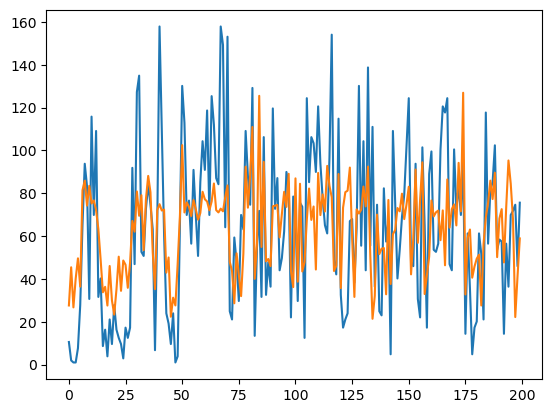

In [7]:
with open(f'Results/TrafficData/trafficData_{dataflow}_LenWindow{lenWindow}.pkl', 'rb') as f:
    trafficData = pickle.load(f)

print(trafficData['trafficTarget_test_actual'].shape)
print(trafficData['trafficTarget_test_predicted'].shape)

plt.plot(trafficData['trafficTarget_test_actual'][0:200])
plt.plot(trafficData['trafficTarget_test_predicted'][0:200])
plt.show()